# LIB

In [1]:
# General Libs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import keras
import datetime
from contextlib import redirect_stdout

# Current files
from generator import Basic_Generator, Full_Diff_Generator, Pic_Generator, Max_Pic_Generator, Has_Pic_Generator
from preprocess import ProdKernel, FKernel, VarSuppression, Zero_One,  Level_Normalizer, Normalizer, DictPrepross
from generator import FC_Generator

from utils import Load_FLX_dict, Plot_Batch
from CST import CST

data_folder=  'Data3'#sCST.Data_folder(CST)
model_folder = CST.Model_folder(CST)
log_folder = CST.Log_folder(CST)

seed=0
batch_size=32
np.random.seed(seed)

def identity(x):
    return(x)

def Log(x): 
    return(np.log(1 - x + 0.1))

Using TensorFlow backend.
/usr/lib/python3/dist-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.24.2) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


# PREPROSS

In [2]:
D=[Load_FLX_dict('DictPrepross2.hdf5')]
#del(D[0].dict['qi'])
#del(D[0].dict['ql'])
#del(D[0].dict['ri'])
#del(D[0].dict['rl'])

In [3]:
Klist0 = []
Klist = []


D2 = [DictPrepross(['o3','pl','q'], 
     [Level_Normalizer(False), Level_Normalizer(False), Level_Normalizer(False)] )]

fit_genator =Max_Pic_Generator(folder=data_folder, batch_size=10*batch_size, chosen_var=['flxd', 'flxu'],
                                  train=True, preprocess_x=D+Klist0, custom_b_p_e=0)
fit_genator.max_b=50
D2[0].fitonGen(fit_genator, axis=2)
del(fit_genator)

In [4]:
# V

V = [VarSuppression(['fcld', 'ri', 'rl'])]
##### Full Preprocessing :
FP = D + Klist + D2 + V

##### b_size
np.random.seed(0)
train_generator =  Has_Pic_Generator(folder=data_folder, batch_size=batch_size, train=True, 
                                         preprocess_x=FP, chosen_var=['flxd', 'flxu'])

validation_generator = Has_Pic_Generator(folder='Data', batch_size=batch_size, train=False, 
                                             preprocess_x=FP, chosen_var=['flxd', 'flxu'])
validation_generator.max_b = 500

header_x = train_generator.used_variables
header_y = train_generator.true_variables_pred

in_channel=len(header_x)
o_channel = len(header_y)
lev=72

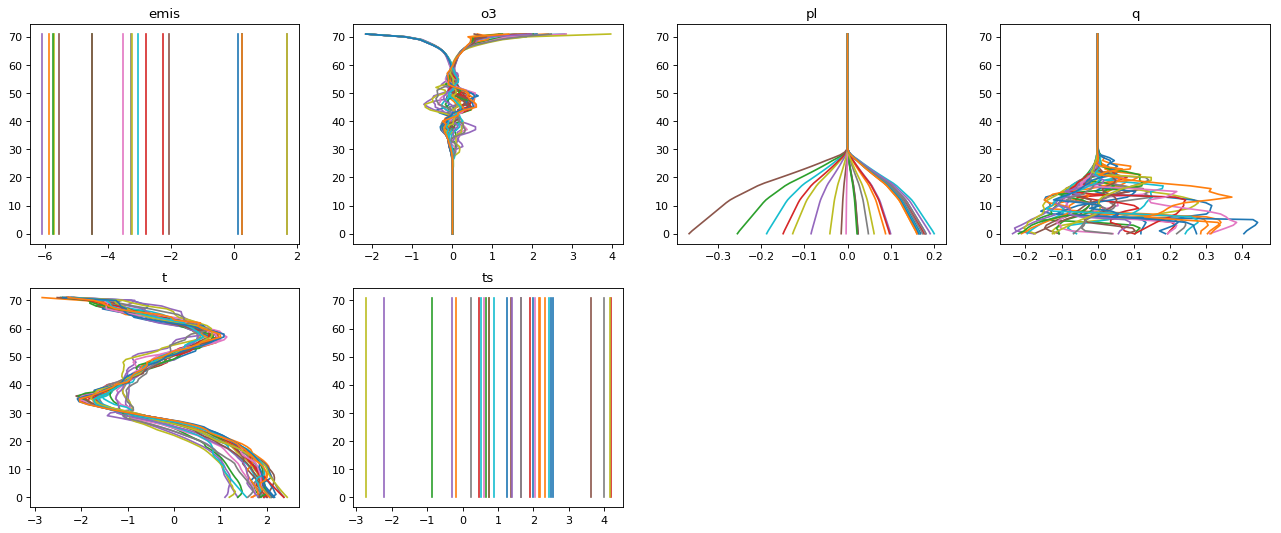

In [5]:
x,y = train_generator[500]
Plot_Batch(x, header_x)

In [9]:
import keras
from keras.models import Sequential
import tensorflow as tf
from architectures import AE, Unet_Act_Double, Contraction, Bidir_Casual_Conv
from architectures_simples import Upsampler, Divide_Recombine
from architectures_utils import total_loss, flxd_loss, flxu_loss, dfdts_loss, LossHistory,  Generate_Log, Name
from keras.layers import Dense, Flatten, Reshape, Lambda, Input, Activation

import keras.backend as K
from keras import optimizers
from keras.layers import Dropout
import datetime
from keras.layers import Bidirectional, LSTM
lev=72

inter_cha = 128
list_of_filters_ae =  [[in_channel, in_channel],
                         [256, 256, 512, 512, 128, 128], 
                         [120]]

list_of_kernel_ae =  [[10, 10],
                        [2, 5, 2, 5, 2, 4], 
                        []]
params_ae = [0.01]
reg = 1e-6

list_of_activation_ae =  [['relu', 'relu'], 
                             ['relu', 'relu', 'relu', 'relu', 'relu', 'relu'],
                             ['relu', 'relu', 'relu']]

M_unet =  Contraction(list_of_kernel_ae, list_of_filters_ae, list_of_activation_ae,
                         params_ae, Div=3, lev=CST.lev(CST), in_channel=2*inter_cha, reg=reg)
M = Sequential()
M.add(Bidirectional(LSTM(inter_cha, return_sequences=True, use_bias=True),input_shape=(72, in_channel), name='Bidir'))
M.add(M_unet)
M.add(Dense(1, activation='sigmoid'))
M.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Bidir (Bidirectional)        (None, 72, 256)           138240    
_________________________________________________________________
model_4 (Model)              (None, 1080)              3362976   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1081      
Total params: 3,502,297
Trainable params: 3,502,297
Non-trainable params: 0
_________________________________________________________________


In [10]:
M_unet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Origin_Input (InputLayer)    (None, 72, 256)           0         
_________________________________________________________________
Conv_0 (Conv1D)              (None, 72, 6)             15360     
_________________________________________________________________
relu_0 (Activation)          (None, 72, 6)             0         
_________________________________________________________________
Conv_1 (Conv1D)              (None, 72, 6)             360       
_________________________________________________________________
relu_1 (Activation)          (None, 72, 6)             0         
_________________________________________________________________
AVG_100 (AveragePooling1D)   (None, 36, 6)             0         
_________________________________________________________________
Conv_100 (Conv1D)            (None, 36, 256)           3328      
__________

In [17]:
import tensorflow as tf
from keras.utils import np_utils

def LogLoss(y_true, y_pred, coef=[1, 100, 10]):
    # Convertion
    y0 = tf.cast(y_true[:,:,-1], dtype=tf.int32)
    y0 = tf.one_hot(y0, depth=2,axis=-1)    
    y1 = tf.convert_to_tensor(y_pred, dtype=tf.float32)

    # Cross Loss
    L =- y0[:,:,0]*K.log(y1[:,:,0]+0.000001)*coef[0]
    L -= y0[:,:,1]*K.log(y1[:,:,1]+0.000001)*coef[1]
    
    L = coef[2]*K.sum(L, axis=1)
    return(L)

def LogLoss_one_hot(y_true, y_pred, coef=[50, 1, 10]):
    # Convertion
#    print(y_true.shape, y_pred.shape)
    y0 = tf.cast(y_true, dtype=tf.int32)
    y0 = K.max(y0, axis=-1)
    y0 = 1 - tf.one_hot(y0, depth=1,axis=-1)    
    y1 = tf.convert_to_tensor(y_pred, dtype=tf.float32)

    L =- y0[:,0]*K.log(y1[:,0]+0.000001)*coef[0]
    L -= (1-y0[:,0])*K.log(  (1-y1[:,0])+0.000001)*coef[1]
    L = tf.expand_dims(L, axis=1)
    L = coef[2]*L#K.sum(L, axis=1)
    return(L)


def Accuracy(y_true, y_pred):
    pred = tf.less(-y_pred, -0.5)
    pred = tf.cast(pred ,tf.float32)
    Ac1 = pred[:,0]*y_true[:,0]
    Ac2 = (1-pred[:,0])*(1-y_true[:,0])
    return (Ac1+Ac2)

def Precision(y_true, y_pred):
#    print(y_pred)
    pred = tf.less(-y_pred, -0.5)
    pred = tf.cast(pred ,tf.float32)
    TP = (pred[:,0]*y_true[:,0])*32
#    print(K.get_value(pred[:,0]))
    Ac1 = TP / tf.cast(K.sum(pred[:,0])+0.0001, tf.float32) 
    return Ac1

def Pics(y_true, y_pred):
    return(y_true[:,0])

x,y = train_generator[0]
y0 = M.predict(x)
K.get_value(LogLoss_one_hot(y,y0))
a=K.get_value(Accuracy(y,y0))
p=K.get_value(Precision(y,y0))

In [18]:
from keras import optimizers
from keras.losses import mean_squared_error
from architectures_utils import LossHistory, Generate_Log
import datetime
import keras_metrics

ES = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, restore_best_weights=True)
prefix = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
archi = 'LSTM_Unet'

LH = LossHistory(frequency=train_generator.batch_per_file, losses=['loss'])
Adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-7, amsgrad=False)
M.compile(loss = LogLoss_one_hot, optimizer=Adam, metrics=[LogLoss_one_hot, keras_metrics.precision(), keras_metrics.recall()])
M.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Bidir (Bidirectional)        (None, 72, 256)           138240    
_________________________________________________________________
model_4 (Model)              (None, 1080)              3362976   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1081      
Total params: 3,502,297
Trainable params: 3,502,297
Non-trainable params: 0
_________________________________________________________________


In [19]:
validation_generator.max_b=0
history = M.fit_generator(train_generator, validation_data=validation_generator, callbacks=[ES, LH], verbose=1, shuffle=False, epochs=10)

Epoch 1/10
7265/7265 [==============================] - 1223s 168ms/step - loss: 18.5770 - LogLoss_one_hot: 18.5740 - precision: 0.0533 - recall: 0.9708 - val_loss: 17.0781 - val_LogLoss_one_hot: 17.0750 - val_precision: 0.0456 - val_recall: 0.9796
Epoch 2/10
1189/7265 [===>..........................] - ETA: 18:02 - loss: 16.4903 - LogLoss_one_hot: 16.4821 - precision: 0.0652 - recall: 0.9184

KeyboardInterrupt: 

In [21]:
len(train_generator)*32

232480

In [23]:
nbp=0
for x,y in train_generator:
    nbp+=np.sum(y)

In [26]:
print(nbp/len(train_generator)/32)

0.04774174122505162


In [16]:
# IMPORTANT MODEL LOG SAVER

file = os.path.join(log_folder, prefix+archi+'.txt')
M.save_weights(os.path.join(model_folder, prefix+archi))
with open(file, 'w') as f:
    with redirect_stdout(f):
        print('Seed {}'.format(seed))
        print('Optimizer')
        print(Adam.get_config())
        print('Prepross')
        for P in FP:
            print(P)
        M.summary
        for i, model in enumerate(M.layers):
            if( str(type(model)) == '<class \'keras.engine.training.Model\'>'):
                model.summary()
#        for k in history.history.keys():
#            print(k,':', history.history[k])
        print('\n')
        print('Unet')
        print('list_of_filters_unet = ',list_of_filters_ae)
        print('list_of_kernel_unet = ',list_of_kernel_ae)
        print('list_of_activation_unet = ', list_of_activation_ae)
#        for loss in LH.losses:
#            print(loss)
#            print(LH.losses[loss])

In [17]:
# This validation generator is a Pic_Generator so we can see the output
validation_generator2 = Pic_Generator(folder='Data', batch_size=batch_size, train=False, 
                                             preprocess_x=FP, chosen_var=['flxd', 'flxu'])

In [21]:
from utils import F_and_plots, Plot_diff
j=np.random.randint(len(validation_generator2))
print(j)
x,y = validation_generator2[j]

y_truth = np.max(y[:,:,0], axis=-1).reshape(-1,1)
y0 = M.predict(x)

965


28.339542
28.339453


In [23]:
print(y_truth.T)
print(y0.T)

[[25.59312439 29.15842438 24.20191956 49.22793579 26.63477325 40.99188232
  29.53062439 31.23855591 23.71861267 29.12879944 30.08709717 24.21634674
  25.15575409 26.48345184 24.13598633 24.77706146 27.55871582 24.70580292
  18.77610016 25.85469055 38.98046875 20.26951599 23.50474548 40.480896
  20.0511322  29.46055603 39.16793823 29.91896057 33.40275574 21.0333252
  25.71779633 23.7015686 ]]
[[30.39226  32.789738 31.269764 44.1767   30.98566  41.645058 31.548092
  32.500023 31.121138 33.328518 30.83044  37.28741  30.57286  31.493656
  36.74136  29.100824 30.897413 32.557503 30.062014 37.609825 42.01667
  29.370262 31.151014 33.222046 31.279863 32.77837  32.511887 33.3613
  32.56268  31.278757 32.395836 30.508942]]


In [32]:
pred = (y0>0.5).astype(int).T
correct = (pred.flatten()*y_truth.flatten()) + (1 - pred.flatten())*(1-y_truth.flatten())
FP = (pred.flatten()*(1-y_truth.flatten()))
TN = (1-pred.flatten())*(1-y_truth.flatten())

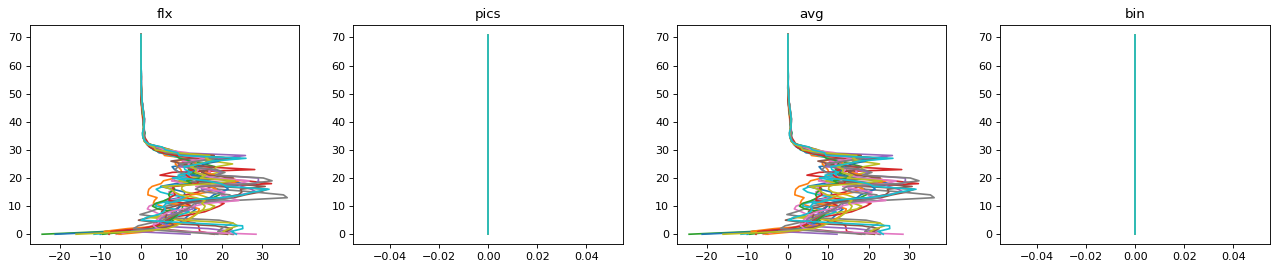

In [33]:
Plot_Batch(y[np.where(correct==1)[0]], ['flx', 'pics', 'avg', 'bin'] )

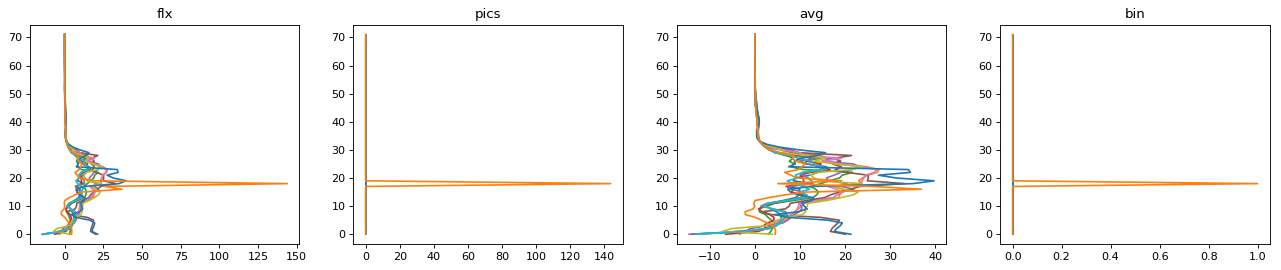

In [34]:
Plot_Batch(y[np.where(correct==0)[0]], ['flx', 'pics', 'avg', 'bin'] )

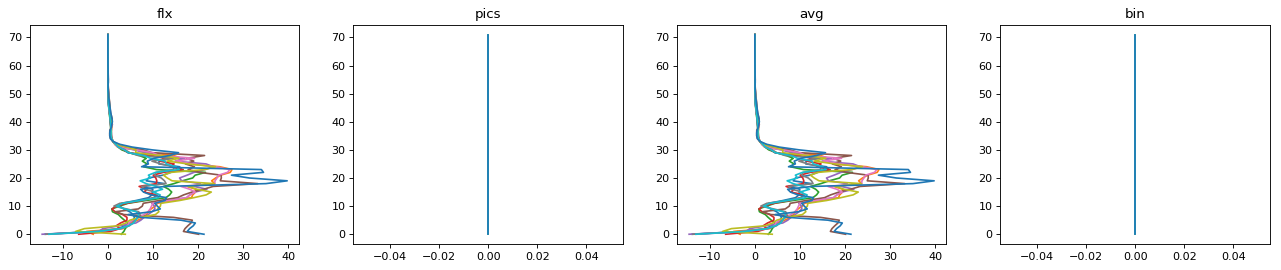

In [35]:
Plot_Batch(y[np.where(FP==1)[0]], ['flx', 'pics', 'avg', 'bin'] )

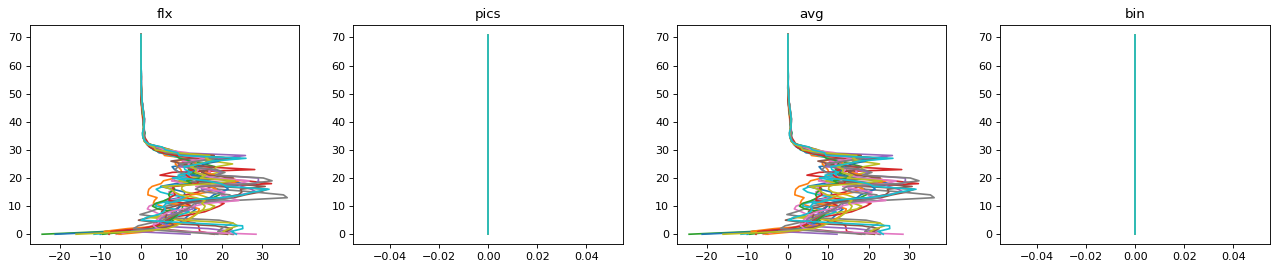

In [36]:
Plot_Batch(y[np.where(TN==1)[0]], ['flx', 'pics', 'avg', 'bin'] )

################################################

In [115]:
np.std(y[:,:,0], axis=1) * np.max(y[:,:,-1], axis=1)

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , 12.67766289,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , 16.06014101,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  8.00243785,  0.        ,
        0.        ,  0.        ])

In [116]:
np.std(y[:,:,0], axis=1)

array([ 8.44018945,  4.8086794 ,  7.81805505,  4.78451419,  4.24440855,
        7.30109338, 12.67766289,  9.95846187,  7.13396902,  9.00866322,
        9.43741242,  6.06569297,  7.08384561,  8.57778901,  7.6794064 ,
        5.14821125,  4.51248874,  4.85900513, 16.06014101,  8.0483506 ,
        4.81822202,  4.28663988,  8.0639527 ,  9.23197598,  4.51892747,
        7.7692537 ,  7.24770188,  9.03920818,  8.00243785,  7.9839531 ,
        7.97237372,  7.46188809])

In [117]:
np.max(np.std(y[:,:,0], axis=1))

16.060141008741386

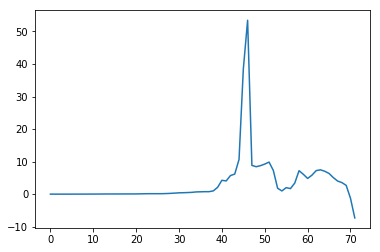

In [118]:
plt.plot(y[-4,:,0])